# Deep Learning Inversion - MT Case
## Part 2 - Deep Learning Training
#### Leo Dinendra - https://github.com/leocd91

## Importing Packages

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset  
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from pytorch_msssim import MS_SSIM, ms_ssim, SSIM, ssim #!pip install pytorch-msssim
from torchinfo import summary #!pip install torchinfo
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import random

## Training Parameter

In [3]:
batch_size = 16
n_epoch = 10
learning_rate = 1e-3

## Dataset Loading

In [4]:
dataset_loc = './dataset'

In [5]:
# Get a list of all files in the folder
all_files = os.listdir(dataset_loc)

# Filter files containing the string 'data' in their filename
filtered_files = [file for file in all_files if 'model' in file]

In [6]:
#check how many data we got
len(filtered_files)

1000

### Making Dataset Class

In [12]:
class MTDataset(Dataset):
    def __init__(self, dataset_list, test=False, log_tranf=False): #test flag in case I want to augment the training set later
        self.dataset_list = dataset_list
        self.test = test
        self.log_tranf = log_tranf
    def __len__(self):
        return len(self.dataset_list)

    def __getitem__(self, idx):
        fname = dataset_loc + '//' + self.dataset_list[idx]
        
        #edit following values for normalizing data
        model_min_value = 0
        model_max_value = 1000
        phase_min_value = -180
        phase_max_value = 180
        apprho_min_value = 0
        apprho_max_value = 100
        
        rhoxy = torch.from_numpy(np.load(fname.replace('model','rhoxy'))).unsqueeze(0)
        rhoyx = torch.from_numpy(np.load(fname.replace('model','rhoyx'))).unsqueeze(0)
        phasexy = torch.from_numpy(np.load(fname.replace('model','phsxy'))).unsqueeze(0)
        phaseyx = torch.from_numpy(np.load(fname.replace('model','phsyx'))).unsqueeze(0)
        
        if self.log_tranf:
            rhoxy = torch.log(rhoxy)
            rhoyx = torch.log(rhoyx)
            phasexy = (phasexy - phase_min_value) / (phase_max_value - phase_min_value)
            phaseyx = (phaseyx - phase_min_value) / (phase_max_value - phase_min_value)
        
        else:
            rhoxy = (rhoxy - apprho_min_value) / (apprho_max_value - apprho_min_value)
            rhoyx = (rhoyx - apprho_min_value) / (apprho_max_value - apprho_min_value)
            phasexy = (phasexy - phase_min_value) / (phase_max_value - phase_min_value)
            phaseyx = (phaseyx - phase_min_value) / (phase_max_value - phase_min_value)
        
        data = torch.vstack([rhoxy, rhoyx, phasexy, phaseyx]).float()
        data = F.interpolate(data.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze() #resize data & label to multiply of 8 for an easier way to modify model architecture later
        label = torch.from_numpy(np.load(fname)).float()
        
        if self.log_tranf:
            label = torch.log(label)
        else:
            label = (label - model_min_value) / (model_max_value - model_min_value)
        
        label = F.interpolate(label.unsqueeze(0).unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze()
        return data, label

### Making Dataloader, Check Data

In [13]:
random.shuffle(filtered_files)

In [14]:
train_data = MTDataset(filtered_files[:850], log_tranf=True) # split 85/15 train test, logarithmic transform due to nature of the MT data
test_data = MTDataset(filtered_files[850:], log_tranf=True)
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
testloader = DataLoader(train_data, batch_size = batch_size, shuffle=False)

In [15]:
#testing dataset
testdata, testlabel = train_data[0]

In [16]:
testdata.shape

torch.Size([4, 64, 64])

In [17]:
testlabel.shape

torch.Size([64, 64])

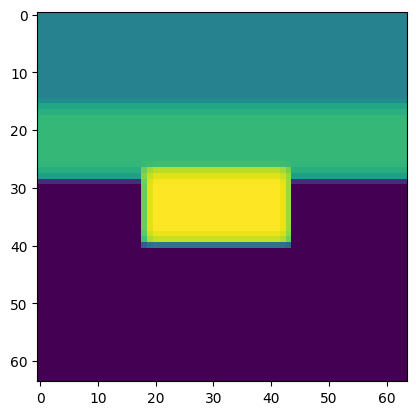

In [18]:
plt.imshow(testlabel.numpy())

## Model Architecture

In [19]:
# https://www.kaggle.com/code/truthisneverlinear/attention-u-net-pytorch
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

In [20]:
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=3, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

In [21]:
model = AttentionUNet(in_channel=4).cuda()

In [22]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')  # Move to GPU
else:
    device = torch.device('cpu')  # Stay on CPU
model = model.to(device)

In [23]:
summary(model, input_size=(1, 4, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
AttentionUNet                            [1, 1, 64, 64]            --
├─ConvBlock: 1-1                         [1, 64, 64, 64]           --
│    └─Sequential: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           2,368
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-6                    [1, 64, 64, 64]           --
├─MaxPool2d: 1-2                         [1, 64, 32, 32]           --
├─ConvBlock: 1-3                         [1, 128, 32, 32]          --
│    └─Sequential: 2-2                   [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-7                  [1, 128, 32, 32]          73,856
│ 

## Training

In [24]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

In [26]:
#use custom SSIM Loss + L1 Mae Loss
class SSIM_Loss(SSIM):
    def forward(self, img1, img2):
        return 100*( 1 - super(SSIM_Loss, self).forward(img1, img2) )

In [27]:
criterion1 = SSIM_Loss(data_range=1.0, size_average=True, channel=1)

In [28]:
criterion2 = nn.L1Loss()

In [29]:
# Training loop
val_loss_old = 999999
train_loss_hist = []
val_loss_hist = []
for epoch in range(n_epoch):  # Number of epochs
    
    model.train()
    train_loss = 0.0
    for i, (x,y) in enumerate(tqdm(trainloader)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion1(outputs, y.unsqueeze(1))*0 + criterion2(outputs, y.unsqueeze(1))*1
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        validation_loss = 0.0
        for i, (x,y) in enumerate(testloader):        
            x = x.to(device)
            y = y.to(device)        
            outputs = model(x)
            loss = criterion1(outputs, y.unsqueeze(1))*0.5 + criterion2(outputs, y.unsqueeze(1))*0.5
            validation_loss += loss.item()
        scheduler.step(loss.item())  # Update learning rate scheduler based on validation loss
        
    if validation_loss < val_loss_old:
        val_loss_old = validation_loss
        torch.save(model.state_dict(), 'best_mt2d_model.pth')
        
    train_loss_hist.append(train_loss / len(trainloader))
    val_loss_hist.append(validation_loss / len(testloader))
    
    if epoch % 1 == 0:  # Print loss every 2 epochs
        print(f'Epoch {epoch}, Training Loss: {train_loss_hist[-1]}, Validation Loss: {val_loss_hist[-1]}')

print('Finished Training')

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00, 10.60it/s]


Epoch 0, Training Loss: 0.9787588196772116, Validation Loss: 25.97132361376727


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.61it/s]


Epoch 1, Training Loss: 0.12822268351360602, Validation Loss: 5.79659484050892


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.56it/s]


Epoch 2, Training Loss: 0.056341241079348105, Validation Loss: 1.8016520451616358


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.50it/s]


Epoch 3, Training Loss: 0.040286362550600814, Validation Loss: 1.0692217570764047


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.47it/s]


Epoch 4, Training Loss: 0.031451175161809834, Validation Loss: 1.5148744114019252


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.46it/s]


Epoch 5, Training Loss: 0.024198955442342494, Validation Loss: 6.633448000307436


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.46it/s]


Epoch 6, Training Loss: 0.02486120367905608, Validation Loss: 1.2695008924713842


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.49it/s]


Epoch 7, Training Loss: 0.026189590942252566, Validation Loss: 3.4628552198410034


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.47it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8, Training Loss: 0.022479424942974693, Validation Loss: 1.5226128233803644


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.42it/s]


Epoch 9, Training Loss: 0.013306605362298864, Validation Loss: 0.026240930099178245
Finished Training


In [30]:
x.min()

tensor(-3.1408, device='cuda:0')

In [31]:
y.max()

tensor(5.6716, device='cuda:0')

## Prediction

In [32]:
model.load_state_dict(torch.load('best_mt2d_model.pth')) # load best model

<All keys matched successfully>

### Making Synthetic Data from Forward Modeller to Predict

In [33]:
from MT2D import * 
from matplotlib.colors import LogNorm
from scipy.ndimage import convolve

In [34]:
alpha = 2.0 # smoothness of gaussian random field,the larger the more smooth;
nza = 0 # number of air layer
yy = 6e3    # lenght in left and right
zz = 4e3    # depth
size_b = 10 # nodes of expand domain
size_k = 47 # nodes of kernel domain
n_freq = 48  # number of frequency data generated
alpha = 3.0
mode = 'random' # if random, 下面是mean和std，if bounda, 是lower和upper
set_1 = 100.0
set_2 = 100.0

In [35]:
def smooth_2d_array(arr, kernel_size=3):
    '''
    arr : 2D array input
    kernel_size : a NxN kernel for smoothing using convolution
    '''
    # Define a kernel (e.g., a simple 3x3 averaging kernel)
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    # Apply convolution to smooth the array
    smoothed_array = convolve(arr, kernel, mode='nearest')

    return smoothed_array

In [36]:
def generate_model(nza, y, z, size_b, size_k, n_freq, alpha = 3.0, mode='random', set_1=100.0, set_2=100.0):
    '''
    nza   : number of air layer
    y     : [-y,y]
    z     : [0,z]: 
    size_b: number of nodes from boundary to kernel domain
    size_k: kernel domain,
    n_freq: number of frequency
    alpha : smoothness of gaussian random field,the larger the more smooth;
    mode  : if random, 下面是mean和std，if bounda, 是lower和upper
    '''
    z_air = np.linspace(-z,0,nza+1)
    zn0 = np.linspace(0, z, size_k+1)
    z_b = np.linspace(zn0[-1],2*zn0[-1],size_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))

    yn0 = np.linspace(-y,y,size_k+1)
    y_l = np.linspace(2*yn0[0],yn0[0],size_b+1)
    y_r = np.linspace(yn0[-1],2*yn0[-1],size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    
    freq = np.logspace(3,-3,n_freq)
    ry = np.linspace(-y,y,size_k+1)

    sig = np.ones((size_b+size_k+nza,2*size_b+size_k))*1e-2
    #sig[:nza,:] = 1e-9 # If you want to make an air layer, uncomment these & give parameter to nza
    sig[:15,:] = 1
    sig[15:25,:] = 10
    sig[25:35,20:45]= 100
    
    return zn, yn, freq, ry, sig

In [37]:
zn, yn, freq, ry, sig = generate_model(nza, yy, zz, size_b, size_k, n_freq, alpha, mode, set_1, set_2)
mtmodel = MT2DFD(nza, zn, yn, freq, ry, sig)
sig = smooth_2d_array(sig, kernel_size=3)
true_rhoxy, true_phsxy,Zxy,true_rhoyx,true_phsyx,Zyx  = mtmodel.mt2d("TETM")

### Model that we will predict

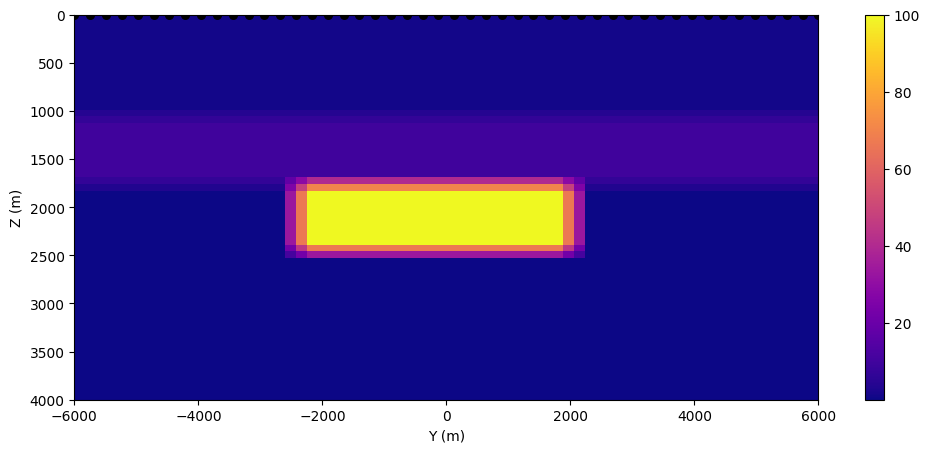

In [38]:
yn0 = np.linspace(-yy,yy,size_k+1)
zn0 = np.linspace(0, zz, size_k+1)
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
h = ax.imshow(sig, interpolation='nearest', cmap='plasma', #norm=LogNorm(vmin=sig.min(), vmax=sig.max()),
              extent=[yn0.min(), yn0.max(), zn0.min(), zn0.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
for y_position in yn0:
    ax.scatter(y_position, zn.min(), color='black', marker='o', s=30, label='Measurement Location')
ax.set_ylabel("Z (m)")
ax.set_xlabel("Y (m)")
fig.colorbar(h)
plt.show()

### testing data transformation

In [39]:
phase_min_value = -180
phase_max_value = 180
rhoxy = torch.from_numpy(true_rhoxy).unsqueeze(0)
rhoyx = torch.from_numpy(true_rhoyx).unsqueeze(0)
phasexy = torch.from_numpy(true_phsxy).unsqueeze(0)
phaseyx = torch.from_numpy(true_phsyx).unsqueeze(0)
rhoxy = torch.log(rhoxy)
rhoyx = torch.log(rhoyx)
phasexy = (phasexy - phase_min_value) / (phase_max_value - phase_min_value)
phaseyx = (phaseyx - phase_min_value) / (phase_max_value - phase_min_value)
        
data = torch.vstack([rhoxy, rhoyx, phasexy, phaseyx]).float()
data = F.interpolate(data.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze() #resize data & label to multiply of 8 for an easier way to modify model architecture later
label = torch.from_numpy(np.log(sig))
label = F.interpolate(label.unsqueeze(0).unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze()

### model prediction

In [40]:
prediction = model(data.unsqueeze(0).cuda()) #need shape batch x channel x Z x Y

In [41]:
prediction = F.interpolate(prediction, size=(57, 67), mode='bilinear', align_corners=False).squeeze()

In [42]:
predlabel = prediction.detach().squeeze().cpu().numpy()

In [43]:
predlabel = np.exp(predlabel)

### prediction results

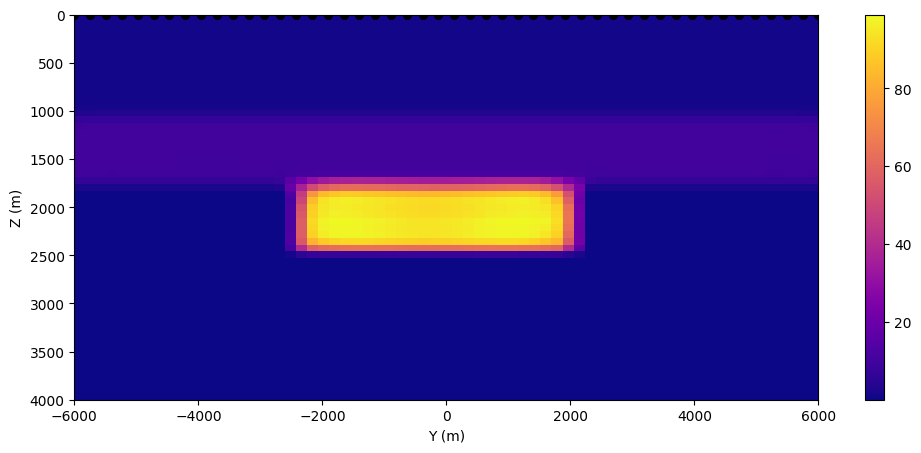

In [46]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
h = ax.imshow(predlabel, interpolation='nearest', cmap='plasma', #norm=LogNorm(vmin=predlabel.min(), vmax=predlabel.max()),
              extent=[yn0.min(), yn0.max(), zn0.min(), zn0.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
for y_position in yn0:
    ax.scatter(y_position, zn.min(), color='black', marker='o', s=30, label='Measurement Location')
ax.set_ylabel("Z (m)")
ax.set_xlabel("Y (m)")
fig.colorbar(h)
plt.show()

### Forward Modelling Based on Model Predicted

In [47]:
mtmodel = MT2DFD(nza, zn, yn, freq, ry, predlabel)
pred_rhoxy, pred_phsxy, pred_Zxy, pred_rhoyx, pred_phsyx, pred_Zyx  = mtmodel.mt2d("TETM")

## Prediction vs Forward Model Difference

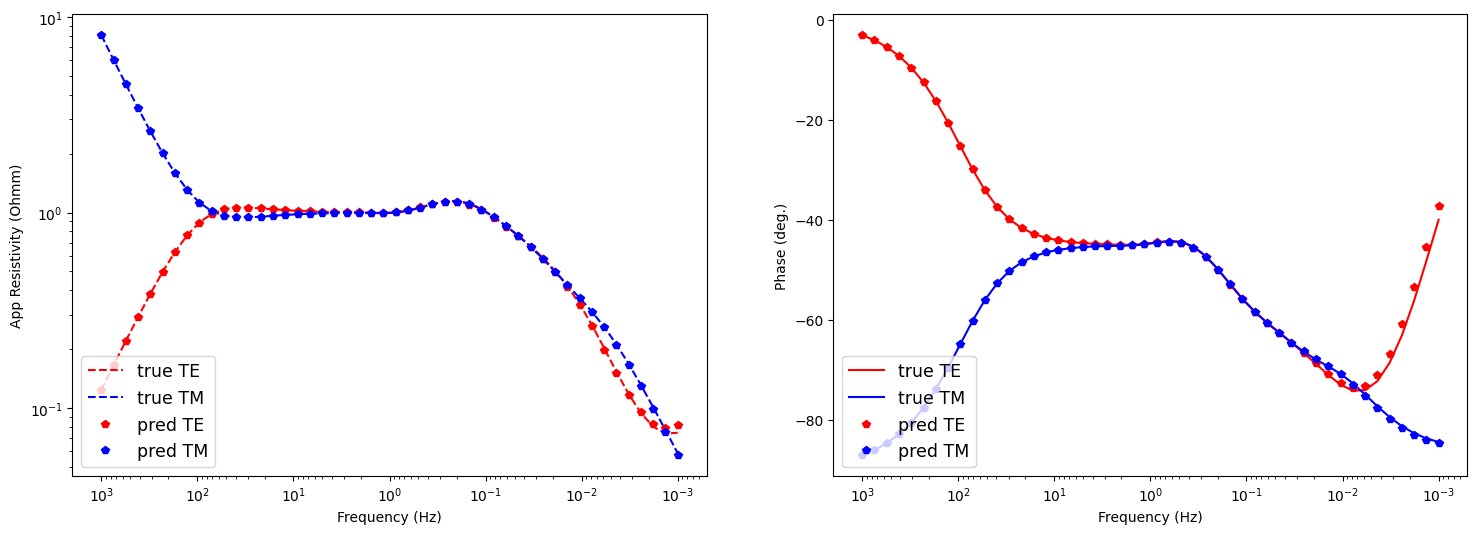

In [48]:
measure_position = 24 #middle
fig = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax.plot(freq, true_rhoxy[:,measure_position], 'r--',label="true TE")
ax.plot(freq, true_rhoyx[:,measure_position], 'b--',label="true TM")
ax.plot(freq, pred_rhoxy[:,measure_position], 'rp',label="pred TE")
ax.plot(freq, pred_rhoyx[:,measure_position], 'bp',label="pred TM")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("App Resistivity (Ohmm)")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
ax = plt.subplot(1,2,2)
ax.plot(freq, true_phsxy[:,measure_position], 'r-',label="true TE")
ax.plot(freq, true_phsyx[:,measure_position]-180, 'b-',label="true TM")
ax.plot(freq, pred_phsxy[:,measure_position], 'rp',label="pred TE")
ax.plot(freq, pred_phsyx[:,measure_position]-180, 'bp',label="pred TM")
ax.set_xscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Phase (deg.)")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
plt.show()

As you can see, it's quite a match!

Let's see model difference.

In [49]:
diff = sig-predlabel

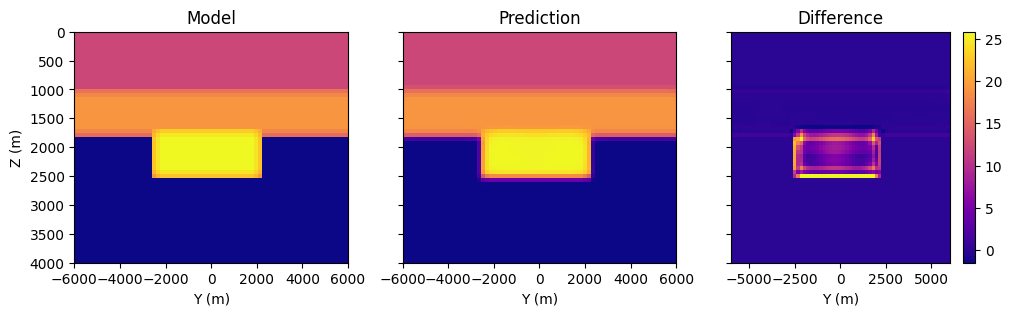

In [65]:
fig = plt.figure(figsize=(12,3))

ax = plt.subplot(1,3,1)
ax.imshow(sig, interpolation='nearest', cmap='plasma', norm=LogNorm(vmin=sig.min(), vmax=sig.max()),
              extent=[yn0.min(), yn0.max(), zn0.min(), zn0.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
ax.set_ylabel("Z (m)")
ax.set_xlabel("Y (m)")
ax.set_title('Model')

ax = plt.subplot(1,3,2)
ax.imshow(predlabel, interpolation='nearest', cmap='plasma', norm=LogNorm(vmin=predlabel.min(), vmax=predlabel.max()),
              extent=[yn0.min(), yn0.max(), zn0.min(), zn0.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
ax.set_xlabel("Y (m)")
ax.set_yticklabels([]) 
ax.set_title('Prediction')

ax = plt.subplot(1,3,3)
h = ax.imshow(diff, interpolation='nearest', cmap='plasma', 
              extent=[yn0.min(), yn0.max(), zn0.min(), zn0.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
ax.set_xlabel("Y (m)")
ax.set_yticklabels([]) 
ax.set_title('Difference')

fig.colorbar(h)
plt.show()

That's it.